In [102]:
import matplotlib.pyplot as plt    # To draw plots
import numpy as np    # To do capping
import os    # General (not used in program)
import pandas as pd    # All Dataframe functions
import seaborn as sns    # To draw different plots
import statsmodels.api as sm    # For ANOVA testing
import statsmodels.regression.linear_model as smf    # For OLS testing

from pandas_profiling import ProfileReport    # For Advanced EDA
from sklearn.linear_model import LinearRegression    # For buildig LR model
from sklearn.metrics import r2_score    # R sqaure test
from sklearn.model_selection import train_test_split    # Split train and test
from sklearn.preprocessing import StandardScaler    # For Standardization
from statsmodels.formula.api import ols    # OLS comparison between two variables
from statsmodels.regression.linear_model import OLS    # For OLS testing (used along with smf from above)
from statsmodels.stats.outliers_influence import variance_inflation_factor    # For checking VIF

#Draw the plots imediately after the current line
%matplotlib inline
sns.set    # To set seaborn's default colour settings and theme

import warnings
warnings.filterwarnings('ignore')    # To not get warnings

In [103]:
dataset = pd.read_csv('01_AirBNB.csv')
dataset.head()

,id,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,instant_bookable,review_scores_rating,bedrooms,beds,log_price
0,6901257,Entire home/apt,3.0,1.0,strict,True,f,100.0,1.0,1.0,5.010635
1,6304928,Entire home/apt,7.0,1.0,strict,True,t,93.0,3.0,3.0,5.129899
2,7919400,Entire home/apt,5.0,1.0,moderate,True,t,92.0,1.0,3.0,4.976734
3,13418779,Entire home/apt,4.0,1.0,flexible,True,f,NaN,2.0,2.0,6.620073
4,3808709,Entire home/apt,2.0,1.0,moderate,True,t,40.0,0.0,1.0,4.744932


In [104]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    74111 non-null  int64  
 1   room_type             74106 non-null  object 
 2   accommodates          74108 non-null  float64
 3   bathrooms             73908 non-null  float64
 4   cancellation_policy   74103 non-null  object 
 5   cleaning_fee          74107 non-null  object 
 6   instant_bookable      74111 non-null  object 
 7   review_scores_rating  57389 non-null  float64
 8   bedrooms              74019 non-null  float64
 9   beds                  73980 non-null  float64
 10  log_price             74111 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 6.2+ MB


## Data Preprocessing
    - Handling duplicates - No duplicates
    - Handling missing values - Done
    - Encoding - Done
    - Handling outliers - Done (hope so)
    - Feature scalling
    - Handling imbalance data

### Handling duplicates

In [105]:
dataset.duplicated().sum()

0

### Handling missing values

In [106]:
dataset.isnull().sum()    # Sum values

id                          0
room_type                   5
accommodates                3
bathrooms                 203
cancellation_policy         8
cleaning_fee                4
instant_bookable            0
review_scores_rating    16722
bedrooms                   92
beds                      131
log_price                   0
dtype: int64

In [107]:
dataset.isnull().sum() / len(dataset) * 100

id                       0.000000
room_type                0.006747
accommodates             0.004048
bathrooms                0.273913
cancellation_policy      0.010795
cleaning_fee             0.005397
instant_bookable         0.000000
review_scores_rating    22.563452
bedrooms                 0.124138
beds                     0.176762
log_price                0.000000
dtype: float64

#### All missing values under 25%, so use imputation method

### Imputation method
   - Check for outliers
   - If there are outliers fill with median
   - If there are no outliers fill with mean

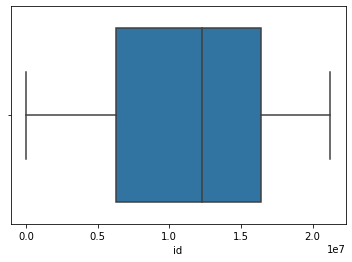

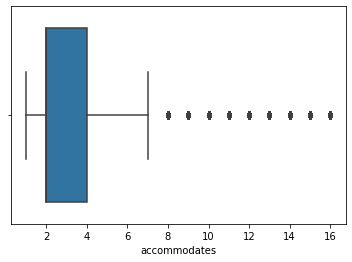

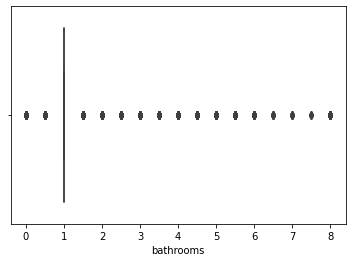

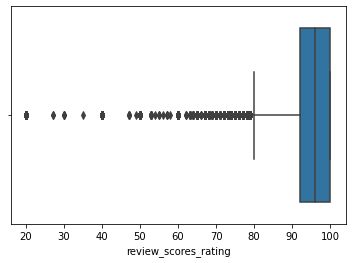

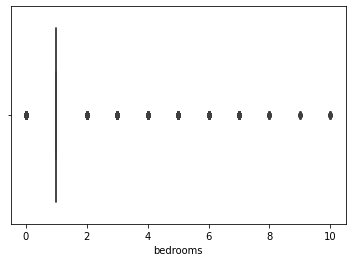

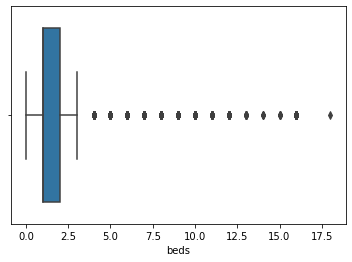

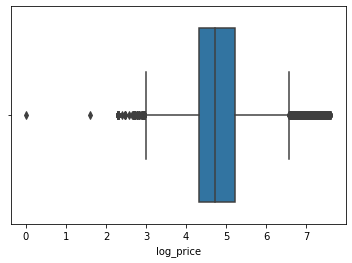

In [108]:
def boxplots(col):
    sns.boxplot(dataset[col])
    plt.show()

for i in list(dataset.select_dtypes(exclude = ['object']).columns)[0:]:
    boxplots(i)

In [109]:
dataset.columns

Index(['id', 'room_type', 'accommodates', 'bathrooms', 'cancellation_policy',
       'cleaning_fee', 'instant_bookable', 'review_scores_rating', 'bedrooms',
       'beds', 'log_price'],
      dtype='object')

In [110]:
dataset['accommodates'] = dataset['accommodates'].fillna(dataset['accommodates'].median())
dataset['bathrooms'] = dataset['bathrooms'].fillna(dataset['bathrooms'].median())
dataset['review_scores_rating'] = dataset['review_scores_rating'].fillna(dataset['review_scores_rating'].median())
dataset['bedrooms'] = dataset['bedrooms'].fillna(dataset['bedrooms'].median())
dataset['beds'] = dataset['beds'].fillna(dataset['beds'].median())

In [111]:
dataset.isnull().sum()

id                      0
room_type               5
accommodates            0
bathrooms               0
cancellation_policy     8
cleaning_fee            4
instant_bookable        0
review_scores_rating    0
bedrooms                0
beds                    0
log_price               0
dtype: int64

In [112]:
room_type_mode = dataset['room_type'].mode()
cancellation_policy_mode = dataset['cancellation_policy'].mode()
cleaning_fee_mode = dataset['cleaning_fee'].mode()

In [113]:
print(room_type_mode)
print(cancellation_policy_mode)
print(cleaning_fee_mode)

0    Entire home/apt
Name: room_type, dtype: object
0    strict
Name: cancellation_policy, dtype: object
0    True
Name: cleaning_fee, dtype: object


In [114]:
dataset['room_type'] = dataset['room_type'].fillna('Entire home/apt')
dataset['cancellation_policy'] = dataset['cancellation_policy'].fillna('strict')
dataset['cleaning_fee'] = dataset['cleaning_fee'].fillna('True')

In [115]:
dataset.isnull().sum()

id                      0
room_type               0
accommodates            0
bathrooms               0
cancellation_policy     0
cleaning_fee            0
instant_bookable        0
review_scores_rating    0
bedrooms                0
beds                    0
log_price               0
dtype: int64

### For Text data
- If insignificant drop
- If significant only proceed with encoding
    - Check using OLS and ANOVA testing method
        - Check p value
        - If p value is more it is insignificant
        - If p value is less than 0.05 it is significant
            - Use ONE HOT or Label encoding

In [116]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    74111 non-null  int64  
 1   room_type             74111 non-null  object 
 2   accommodates          74111 non-null  float64
 3   bathrooms             74111 non-null  float64
 4   cancellation_policy   74111 non-null  object 
 5   cleaning_fee          74111 non-null  object 
 6   instant_bookable      74111 non-null  object 
 7   review_scores_rating  74111 non-null  float64
 8   bedrooms              74111 non-null  float64
 9   beds                  74111 non-null  float64
 10  log_price             74111 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 6.2+ MB


In [117]:
for i in list(dataset.select_dtypes(include = ['object']).columns)[0:]:
    print(i, dataset[i].nunique())

room_type 3
cancellation_policy 3
cleaning_fee 3
instant_bookable 2


In [17]:
#dataset.room_type.values.dtype

### Checking for significance of text variables
    - if p value < 0.05 significant

In [118]:
model = ols('log_price ~ room_type + cancellation_policy + instant_bookable', data = dataset).fit()
anova_result = sm.stats.anova_lm(model, typ = 2)
print(anova_result)

                           sum_sq       df             F        PR(>F)
room_type            13650.126437      2.0  21327.957352  0.000000e+00
cancellation_policy    113.379924      2.0    177.153098  1.764921e-77
instant_bookable        32.952844      1.0    102.975874  3.518421e-24
Residual             23714.006056  74105.0           NaN           NaN


In [119]:
dataset['cleaning_fee'].unique()

array([True, False, 'True'], dtype=object)

In [120]:
dataset.index[dataset['cleaning_fee'] == 'True']

Index([205, 209, 232, 399], dtype='int64')

In [121]:
dataset.index[dataset['cleaning_fee'] == True]

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       74098, 74099, 74100, 74101, 74103, 74104, 74105, 74107, 74108, 74109],
      dtype='int64', length=54399)

In [122]:
dataset['cleaning_fee'] = np.where(dataset['cleaning_fee'] == 'True', True, dataset['cleaning_fee'])

In [123]:
dataset['cleaning_fee'].unique()

array([True, False], dtype=object)

In [124]:
model = ols('log_price ~ room_type + cancellation_policy + instant_bookable + cleaning_fee', data = dataset).fit()
anova_result = sm.stats.anova_lm(model, typ = 2)
print(anova_result)

                           sum_sq       df             F        PR(>F)
room_type            13437.056815      2.0  21010.746669  0.000000e+00
cancellation_policy    116.221282      2.0    181.728481  1.858836e-79
instant_bookable        32.297921      1.0    101.004773  9.503672e-24
cleaning_fee            18.045271      1.0     56.432689  5.880553e-14
Residual             23695.960785  74104.0           NaN           NaN


In [125]:
dataset_copy = dataset   # Copying to have a backup before droping insignificant columns

### cancellaion_policy, cleaning_fee and instant_bookable have p value more than 0.05 so drop them

In [126]:
dataset = dataset.drop(['cancellation_policy' , 'instant_bookable', 'cleaning_fee'] , axis = 1)

In [127]:
dataset.head()

,id,room_type,accommodates,bathrooms,review_scores_rating,bedrooms,beds,log_price
0,6901257,Entire home/apt,3.0,1.0,100.0,1.0,1.0,5.010635
1,6304928,Entire home/apt,7.0,1.0,93.0,3.0,3.0,5.129899
2,7919400,Entire home/apt,5.0,1.0,92.0,1.0,3.0,4.976734
3,13418779,Entire home/apt,4.0,1.0,96.0,2.0,2.0,6.620073
4,3808709,Entire home/apt,2.0,1.0,40.0,0.0,1.0,4.744932


### Proceeding with encoding

In [128]:
dataset = pd.get_dummies(dataset, columns = ['room_type'])

In [129]:
dataset

,id,accommodates,bathrooms,review_scores_rating,bedrooms,beds,log_price,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,6901257,3.0,1.0,100.0,1.0,1.0,5.010635,True,False,False
1,6304928,7.0,1.0,93.0,3.0,3.0,5.129899,True,False,False
2,7919400,5.0,1.0,92.0,1.0,3.0,4.976734,True,False,False
3,13418779,4.0,1.0,96.0,2.0,2.0,6.620073,True,False,False
4,3808709,2.0,1.0,40.0,0.0,1.0,4.744932,True,False,False
...,...,...,...,...,...,...,...,...,...,...
74106,14549287,1.0,1.0,96.0,1.0,1.0,4.605170,False,True,False
74107,13281809,4.0,2.0,93.0,2.0,4.0,5.043425,True,False,False
74108,18688039,5.0,1.0,94.0,2.0,2.0,5.220356,True,False,False
74109,17045948,2.0,1.0,96.0,0.0,2.0,5.273000,True,False,False


## Handling Outliers

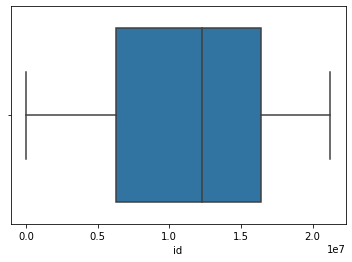

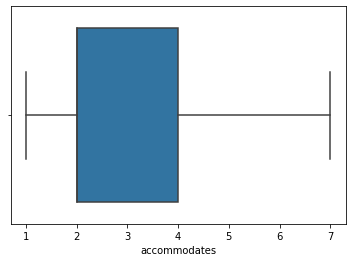

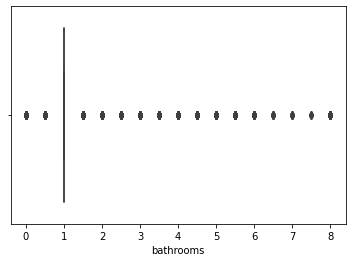

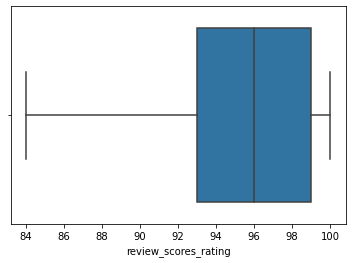

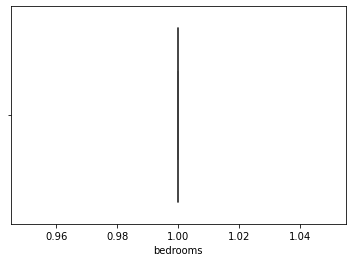

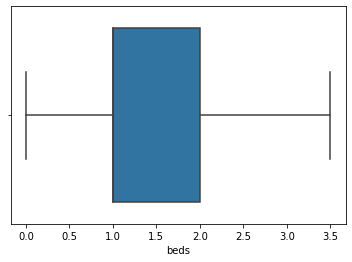

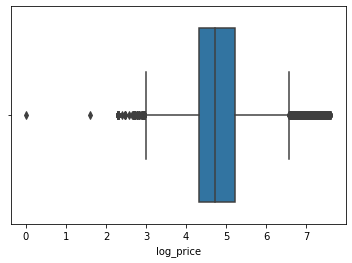

In [143]:
def boxplots2(col):
    sns.boxplot(dataset[col])
    plt.show()

for i in list(dataset.select_dtypes(exclude = ['object','boolean']).columns)[0:]:
    boxplots2(i)

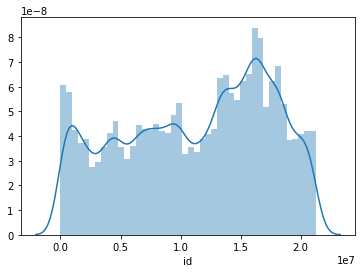

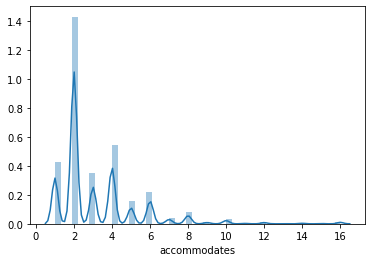

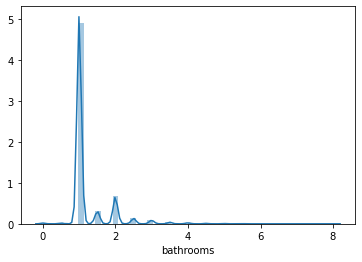

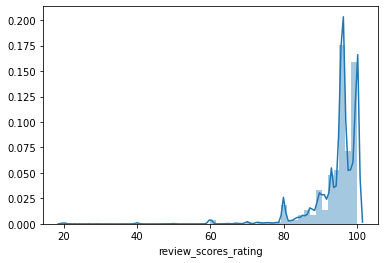

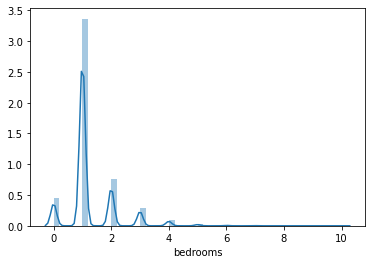

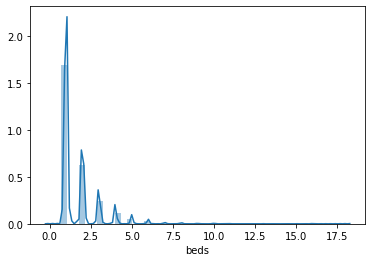

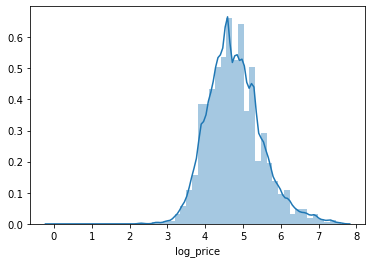

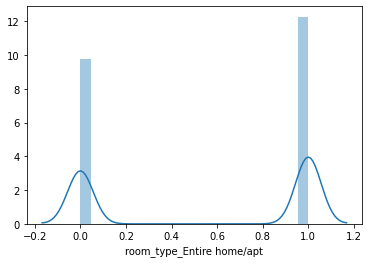

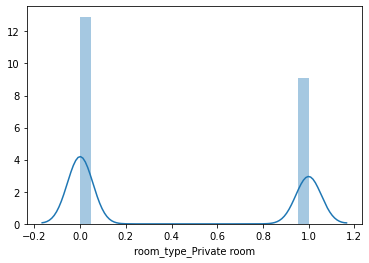

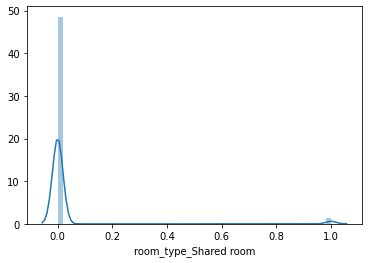

In [131]:
def distplots(col):
    sns.distplot(dataset[col])
    plt.show()
    
for i in list(dataset.columns)[0:]:
    distplots(i)

In [87]:
dataset.columns

Index(['id', 'accommodates', 'bathrooms', 'review_scores_rating', 'bedrooms',
       'beds', 'log_price', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

### Outliers found in - accomodates

In [133]:
# Finding upper and lower limits

accomodates_Q1 = dataset['accommodates'].quantile(0.25)
accomodates_Q3 = dataset['accommodates'].quantile(0.75)
accomodates_iqr = accomodates_Q3 - accomodates_Q1

upper_accomodates = accomodates_Q3 + (1.5 * accomodates_iqr)
lower_accomodates = accomodates_Q1 - (1.5 * accomodates_iqr)

# Capping

dataset['accommodates'] = np.where(dataset['accommodates'] > upper_accomodates, upper_accomodates, 
                                  np.where(dataset['accommodates'] < lower_accomodates, lower_accomodates, 
                                          dataset['accommodates']))

In [149]:
# Finding upper and lower limits

review_scores_rating_Q1 = dataset['review_scores_rating'].quantile(0.25)
review_scores_rating_Q3 = dataset['review_scores_rating'].quantile(0.75)
review_scores_rating_iqr = review_scores_rating_Q3 - review_scores_rating_Q1

upper_review_scores_rating = review_scores_rating_Q3 + (1.5 * review_scores_rating_iqr)
lower_review_scores_rating = review_scores_rating_Q1 - (1.5 * review_scores_rating_iqr)

# Capping

dataset['review_scores_rating'] = np.where(dataset['review_scores_rating'] > upper_review_scores_rating, 
                                           upper_review_scores_rating, np.where(dataset['review_scores_rating'] < 
                                                                                lower_review_scores_rating, 
                                                                                lower_review_scores_rating, 
                                                                                dataset['review_scores_rating']))

In [150]:
# Finding upper and lower limits

bathrooms_Q1 = dataset['bathrooms'].quantile(0.25)
bathrooms_Q3 = dataset['bathrooms'].quantile(0.75)
bathrooms_iqr = bathrooms_Q3 - bathrooms_Q1

upper_bathrooms = bathrooms_Q3 + (1.5 * bathrooms_iqr)
lower_bathrooms = bathrooms_Q1 - (1.5 * bathrooms_iqr)

# Capping

dataset['bathrooms'] = np.where(dataset['bathrooms'] > upper_bathrooms, upper_bathrooms, 
                               np.where(dataset['bathrooms'] < lower_bathrooms, lower_bathrooms, 
                                        dataset['bathrooms']))

In [138]:
# Finding upper and lower limits

bedrooms_Q1 = dataset['bedrooms'].quantile(0.25)
bedrooms_Q3 = dataset['bedrooms'].quantile(0.75)
bedrooms_iqr = bedrooms_Q3 - bedrooms_Q1

upper_bedrooms = bedrooms_Q3 + (1.5 * bedrooms_iqr)
lower_bedrooms = bedrooms_Q1 - (1.5 * bedrooms_iqr)

# Capping

dataset['bedrooms'] = np.where(dataset['bedrooms'] > upper_bedrooms, upper_bedrooms, 
                               np.where(dataset['bedrooms'] < lower_bedrooms, lower_bedrooms, 
                                        dataset['bedrooms']))

In [140]:
# Finding upper and lower limits

beds_Q1 = dataset['beds'].quantile(0.25)
beds_Q3 = dataset['beds'].quantile(0.75)
beds_iqr = beds_Q3 - beds_Q1

upper_beds = beds_Q3 + (1.5 * beds_iqr)
lower_beds = beds_Q1 - (1.5 * beds_iqr)

# Capping

dataset['beds'] = np.where(dataset['beds'] > upper_beds, upper_beds, np.where(dataset['beds'] < lower_beds, lower_beds, 
                                                                              dataset['beds']))

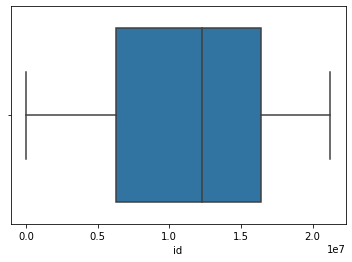

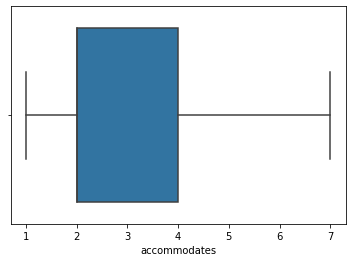

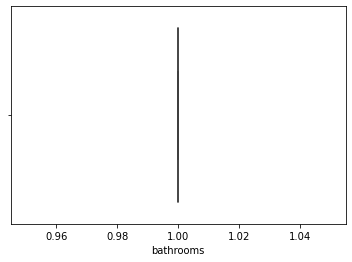

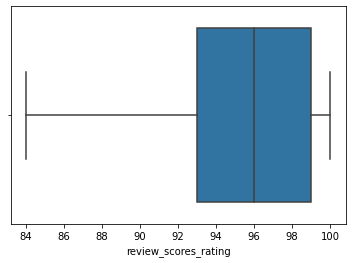

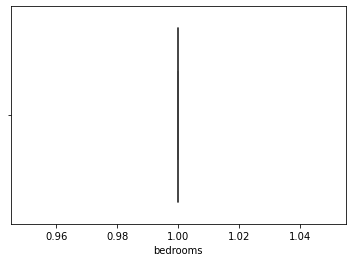

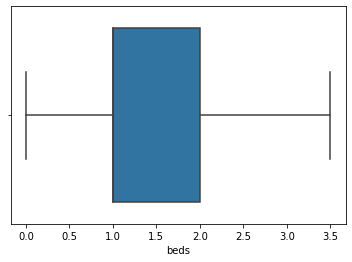

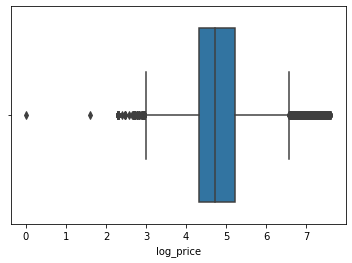

In [151]:
def boxplots3(col):
    sns.boxplot(dataset[col])
    plt.show()

for i in list(dataset.select_dtypes(exclude = ['object','boolean']).columns)[0:]:
    boxplots3(i)

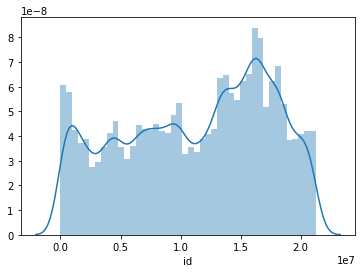

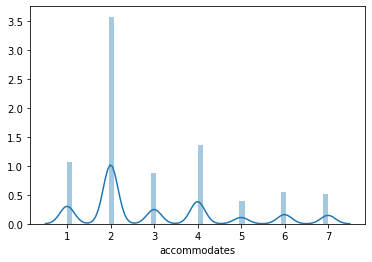

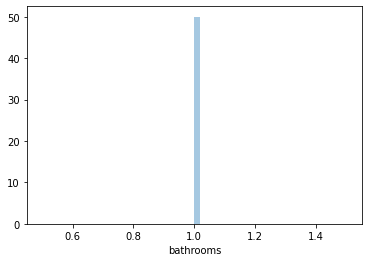

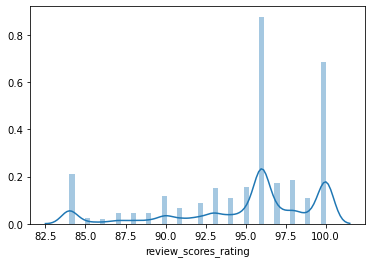

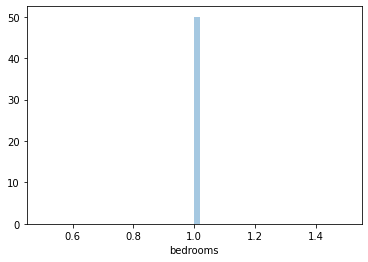

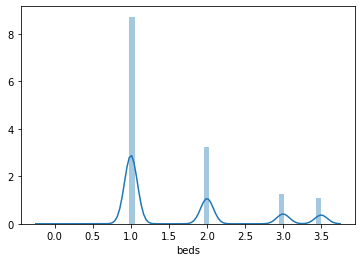

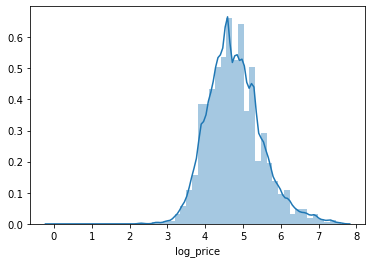

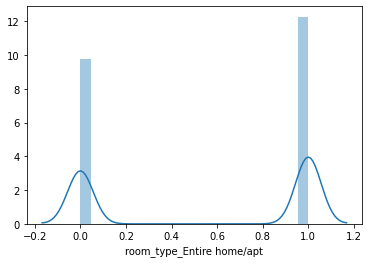

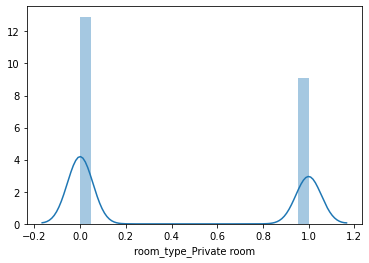

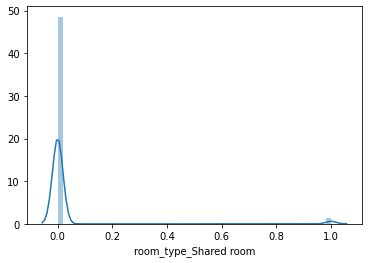

In [152]:
def distplots(col):
    sns.distplot(dataset[col])
    plt.show()
    
for i in list(dataset.columns)[0:]:
    distplots(i)

## Feature Scaling

In [158]:
dataset.describe()

,id,accommodates,bathrooms,review_scores_rating,bedrooms,beds,log_price
count,7.411100e+04,74111.000000,74111.0,74111.000000,74111.0,74111.000000,74111.000000
mean,1.126662e+07,3.018000,1.0,95.098393,1.0,1.590992,4.782069
std,6.081735e+06,1.695008,0.0,4.552731,0.0,0.838687,0.717394
min,3.440000e+02,1.000000,1.0,84.000000,1.0,0.000000,0.000000
25%,6.261964e+06,2.000000,1.0,93.000000,1.0,1.000000,4.317488
50%,1.225415e+07,2.000000,1.0,96.000000,1.0,1.000000,4.709530
75%,1.640226e+07,4.000000,1.0,99.000000,1.0,2.000000,5.220356
max,2.123090e+07,7.000000,1.0,100.000000,1.0,3.500000,7.600402


In [192]:
dataset_copy_before_feature = dataset

In [195]:
dataset['room_type_Entire home/apt'] = dataset['room_type_Entire home/apt'].astype(int)
dataset['room_type_Private room'] = dataset['room_type_Private room'].astype(int)
dataset['room_type_Shared room'] = dataset['room_type_Shared room'].astype(int)

- If the difference is more, then feature scalling should be done
- When you use Gradient descent then feature scalling is mandatory
- For OLS, you have to check model is perfoming better with or without feature scaling and take action accordingly

In [196]:
# split the data into independent and dependent variable
x = dataset.drop(['log_price'], axis=1)
y = dataset[['log_price']]

In [197]:
x.head()

,id,accommodates,bathrooms,review_scores_rating,bedrooms,beds,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,6901257,3.0,1.0,100.0,1.0,1.0,1,0,0
1,6304928,7.0,1.0,93.0,1.0,3.0,1,0,0
2,7919400,5.0,1.0,92.0,1.0,3.0,1,0,0
3,13418779,4.0,1.0,96.0,1.0,2.0,1,0,0
4,3808709,2.0,1.0,84.0,1.0,1.0,1,0,0


In [198]:
y.head()

,log_price
0,5.010635
1,5.129899
2,4.976734
3,6.620073
4,4.744932


In [199]:
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)
pd.DataFrame(x_scaler).head()

,0,1,2,3,4,5,6,7,8
0,-0.717787,-0.010620,0.0,1.076637,0.0,-0.704668,0.891005,-0.839429,-0.173388
1,-0.815840,2.349267,0.0,-0.460912,0.0,1.680028,0.891005,-0.839429,-0.173388
2,-0.550376,1.169324,0.0,-0.680562,0.0,1.680028,0.891005,-0.839429,-0.173388
3,0.353875,0.579352,0.0,0.198038,0.0,0.487680,0.891005,-0.839429,-0.173388
4,-1.226288,-0.600591,0.0,-2.437761,0.0,-0.704668,0.891005,-0.839429,-0.173388


# Checking multi co-linearity

## Using heat map
    - If any data is highly significant that is above 75%, drop it
    - If any IDV vs DV is more than 50% drop it
    - If any two IDVs have the same multi-colineratity, drop any one

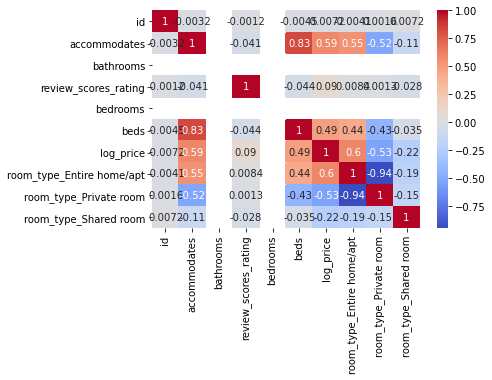

In [200]:
sns.heatmap(dataset.corr(), annot = True, cmap = 'coolwarm')
plt.show()

### Using Variance Inflation Factor (VIF)
    - If VIF > 5, there is multi co-linearity
    - If VIF < 5, there is multi no co-linearity

In [201]:
variable = x_scaler
vif = pd.DataFrame()
vif['Vaiance Inflation Factor'] = [variance_inflation_factor(variable, i) for i in range(variable.shape[1])]
vif['Features'] = x.columns
vif

,Vaiance Inflation Factor,Features
0,1.000079,id
1,3.828529,accommodates
2,NaN,bathrooms
3,1.004002,review_scores_rating
4,NaN,bedrooms
5,3.317365,beds
6,inf,room_type_Entire home/apt
7,inf,room_type_Private room
8,inf,room_type_Shared room


In [202]:
prof = ProfileReport(dataset)
prof.to_file(output_file="EDA_for_Airbnb.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

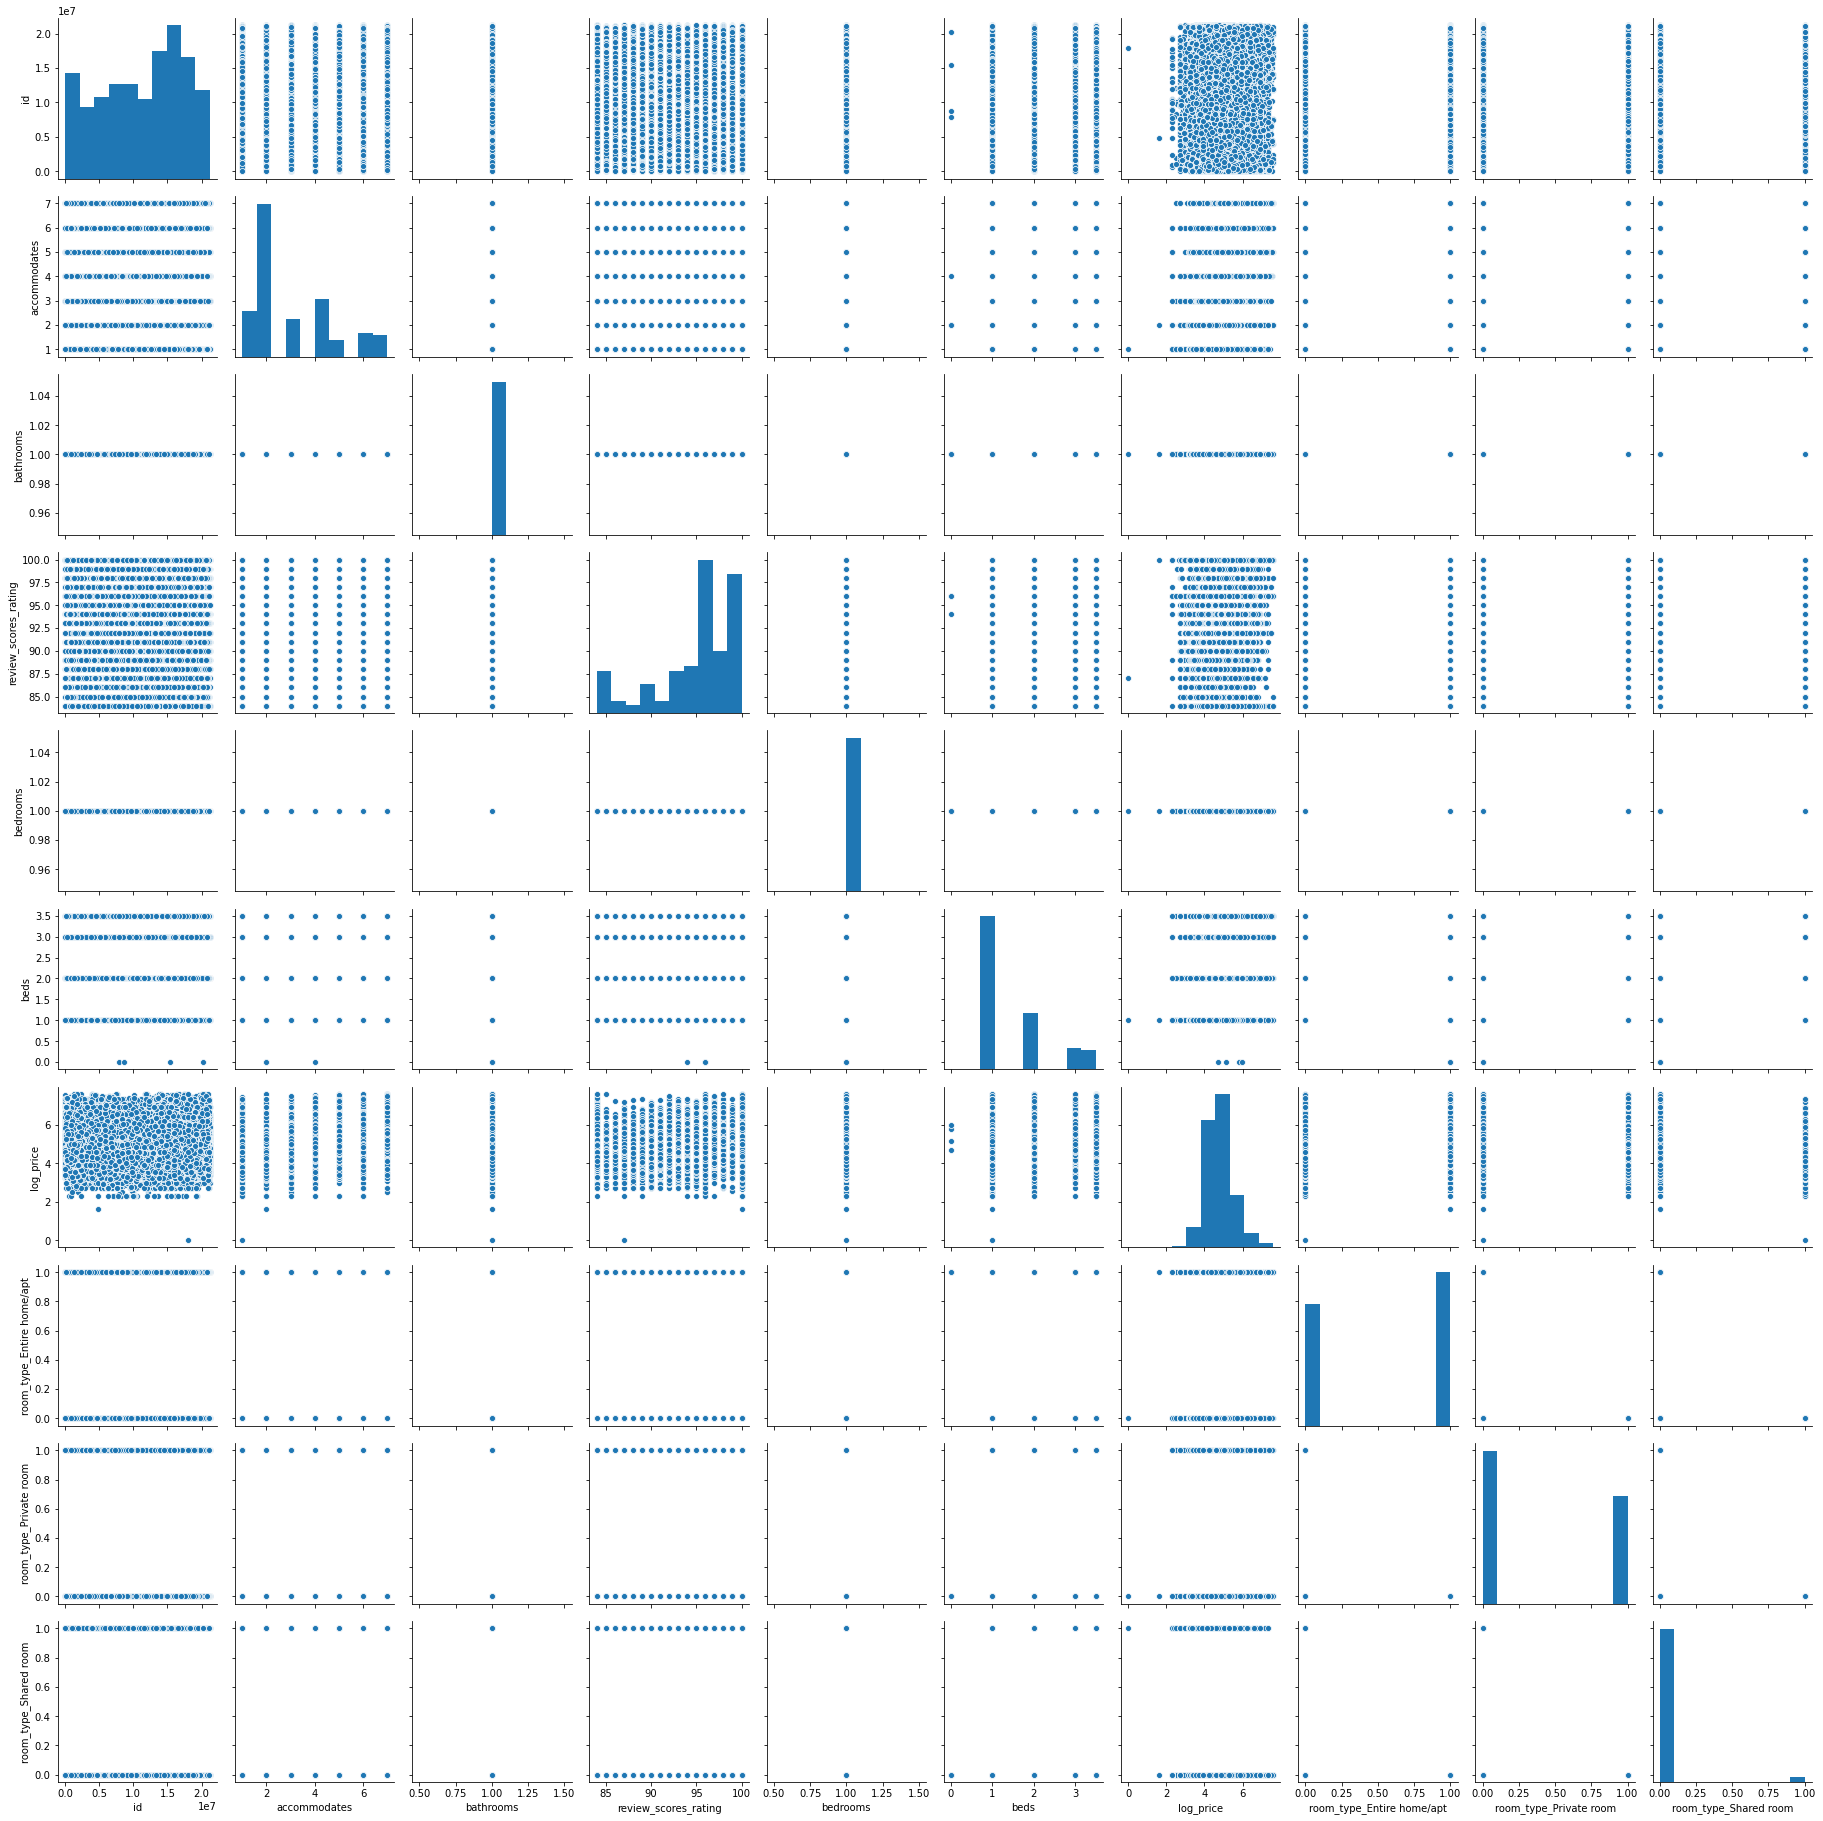

In [203]:
sns.pairplot(dataset)

### Droping coliner and high vif columns

In [206]:
dataset = dataset.drop(['room_type_Entire home/apt','room_type_Private room','room_type_Shared room','accommodates'], axis = 1)

In [207]:
prof = ProfileReport(dataset)
prof.to_file(output_file="EDA_for_Airbnb.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

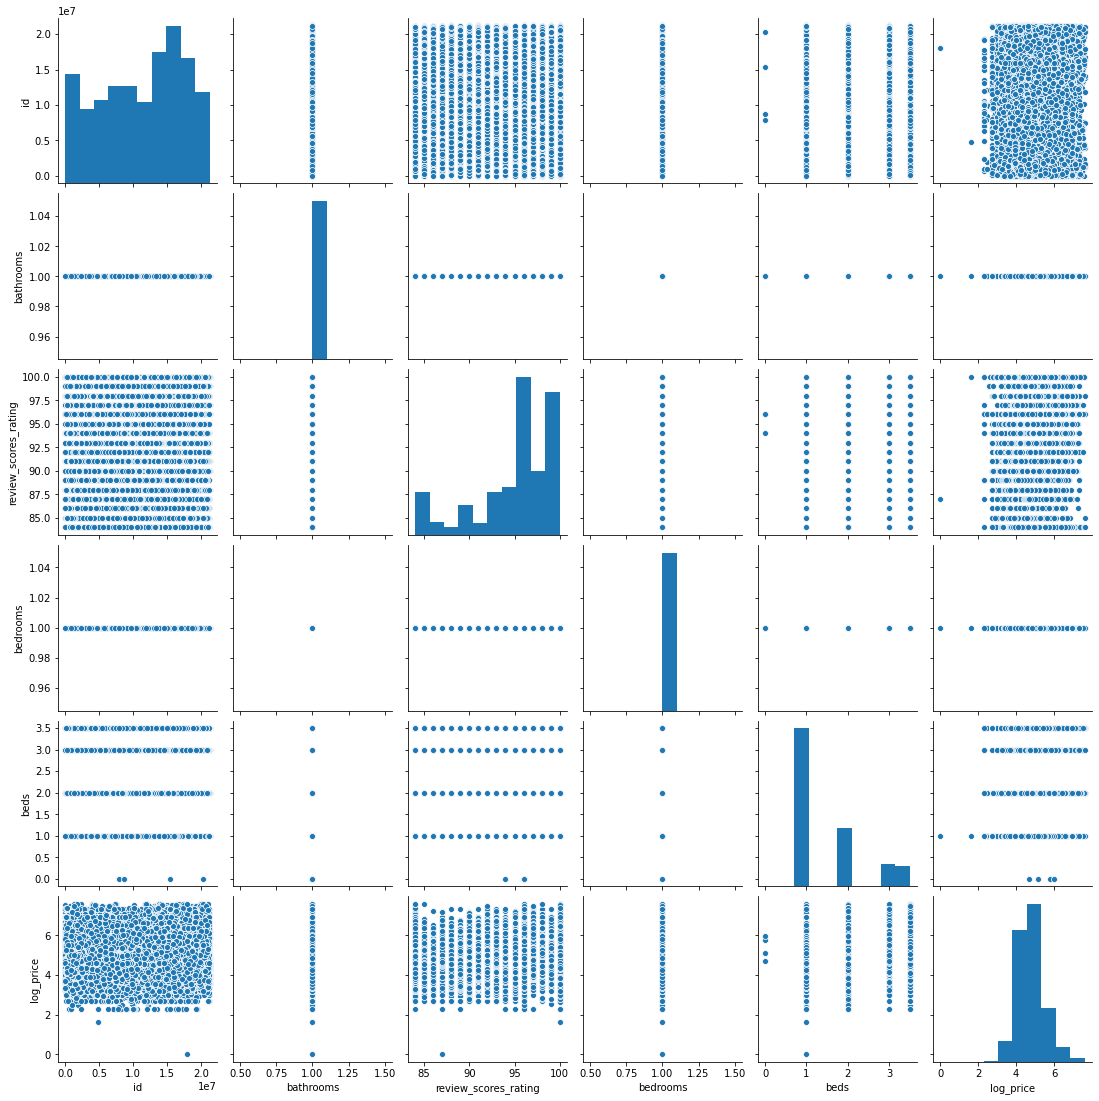

In [208]:
sns.pairplot(dataset)

In [209]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)
regression_model = smf.OLS(endog=y_train, exog=x_train).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     7965.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:50:44   Log-Likelihood:                -39466.
No. Observations:               51877   AIC:                         7.895e+04
Df Residuals:                   51870   BIC:                         7.901e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
id                        -2.254e-10   3.74e-10     -0.603      0.547   -9.58e-10    5.08e-10
accommodates                  0.1471      0.003     56.386      0.000       0.142       0.152
bathrooms                     1.0804      0.021     51.989      0.000       1.040       1.121
review_scores_rating          0.0159      0.001     31.698      0.000       0.015       0.017
bedrooms                      1.0804      0.021     51.989      0.000       1.040       1.121
beds                          0.0305      0.005      6.222      0.000       0.021       0.040
room_type_Entire home/apt     0.8700      0.009     98.788      0.000       0.853       0.887
room_type_Private room        0.3294      0.008     39.438      0.000       0.313       0.346
room_type_Shared room        -0.1190      0.012    -10.175      0.000      -0.142      -0.096
==============================================================================
Omnibus:                     6214.099   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15290.779
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                       5.263   Cond. No.                     7.05e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.71e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [210]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [211]:
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)

In [212]:
print("Training Accuracy ", r2_score(y_train, y_pred_train))
print("Test Accuracy ", r2_score(y_test, y_pred_test))

Training Accuracy  0.47952434219734796
Test Accuracy  0.484881246281589


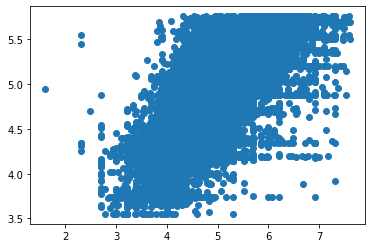

In [213]:
plt.scatter(y_test, y_pred_test)

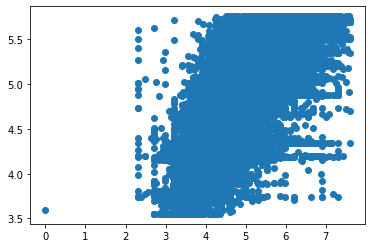

In [214]:
plt.scatter(y_train, y_pred_train)

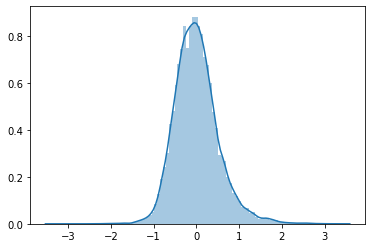

In [215]:
sns.distplot((y_test - y_pred_test), bins=100)

plt.show()

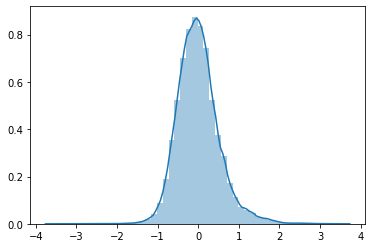

In [216]:
sns.distplot((y_train - y_pred_train), bins=50)

plt.show()